In [117]:
import cv2
import numpy as np
import os
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy.linalg
from sklearn.decomposition import PCA



def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img)
        plt.title(window_name)
        plt.show()

def display_1_rgb(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()

def display_1_gray(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.show()

def display_1_img(name:str, img, mode:str="rgb"):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if mode == "gray":
        plt.imshow(img, cmap="gray")
    elif mode == "fire":
        plt.imshow(img, cmap="inferno")
    else:
        plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()




def plot_points(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               linewidth=2, s=2, alpha=alpha)
    ax.plot(V_plt[:,0], V_plt[:,1], color=fill,
            linewidth=2, alpha=alpha)
    
    return ax

def display_image_with_points(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points(ax, V)

## Sheet 08 
 Authors: Siarhei Sheludzko, Marcel Melchers
### 1 Statistical Shape Modeling

Build a PCA based statistical shape model M using the data in *hands_aligned_train.txt*. <br> The data contains a set of 56 corresponding landmark points on hand-contours from 39 instances, <br> which have already been aligned using Procrustes Analysis.  Refer to the *readme* file for details about the data organization. <br>  The model M is formulated by defining the subspace model as:

$$
    w_i≈μ+\sum_{k=1}^{N}\phi_kh_{ik}
$$

$$
    M = \{\mu, \phi_1, \phi_2, ..., \phi_N \}
$$

where $N$ is the minimum number of principal components preserving 90% of the energy. <br> Visualize μ and the effect of the weights $W = (−0.4,−0.2, 0.0, 0.2, 0.4)$ of
each $\phi_k$.

Remarks: Please implement PCA yourself. You may use *np.linalg.eig* and *np.linalg.svd*.

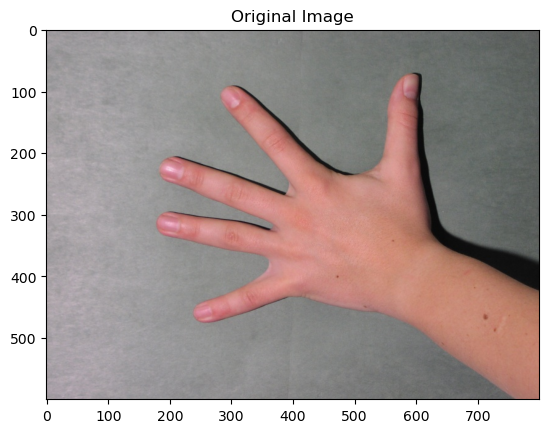

In [8]:
# set image path
path_task1 = './data/task1/hand.jpg'
# read imgs
img_task1 = cv2.imread(path_task1)
display_1_rgb("Original Image", img_task1)


In [9]:
def get_coordinates():
    fpath = './data/task1/hand_landmarks.txt'
    coord_arr = []
    with open(fpath,'r') as f:
        for line in f:
            line = line.replace("(","").replace(")","").strip()
            coord = list(map(int, line.split(",")))
            coord_arr.append(coord)
    return np.array(coord_arr, dtype=np.uint64)

landmark_points = get_coordinates()


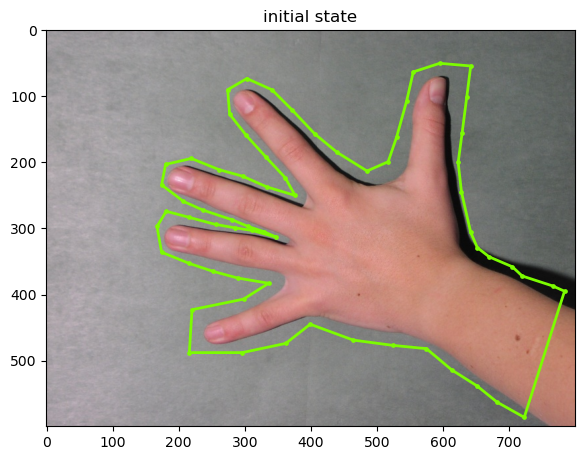

In [10]:
display_image_with_points(img_task1, landmark_points)

In [71]:
def loadData(filename):
    # #return the data points
    # df = pd.read_csv(filename, header = 0)

    # return df
    coord_arr = []
    with open(filename,'r') as f:
        dim = 0
        num = 0
        for i, line in enumerate(f):
            if(i == 0):
                dim , num = list(map(int, line.split("\t")))
            else:
                line = (line.replace("\n", "").split("\t"))
                
                if("train.txt" in filename.split("_")):
                    line = line[:-1]
                coords = list(map(int, line))              
                
                coord_arr.append(coords)   
        coord_arr = np.array(coord_arr, dtype=np.uint64).T
        X_arr = coord_arr[:, :dim//2]
        Y_arr = coord_arr[:, dim//2:]
        coord_arr = np.array([X_arr, Y_arr]).reshape((dim//2, num, 2))
    return coord_arr
    

test_data = loadData('./data/task1/hands_aligned_test.txt')
print("Test Data shape: ", test_data.shape)

train_data = loadData('./data/task1/hands_aligned_train.txt')
print("Train Data shape: ", train_data.shape)

Test Data shape:  (56, 1, 2)
Train Data shape:  (56, 39, 2)


In [104]:
def decomposePCA(dataPoints,  k=None, preservRatio=0.9):
    # implement PCA for task1 yourself and return the first k 
    # components that preserve preservRatio of the energy and their eigen values

    dataPoints = dataPoints.reshape((dataPoints.shape[0]*2, -1))  

    # take one shape as mean shape
    meanShape = np.array([dataPoints[0]])
    

    # subtract mean shape from all shapes
    alignDataPoints = dataPoints - meanShape
    

    # calculate covariance matrix
    covariance_matrix  = np.cov(alignDataPoints)
    # print("Covariance Matrix: ", covariance_matrix.shape)

    # calculate eigen values and eigen vectors of covariance matrix
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    # print("Eigen Values: ", eigen_values.shape)

    # sort eigen values and eigen vectors in descending order
    idx = np.argsort(-eigen_values)
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]

    
    
    if k is not None and preservRatio is None:
        # return first k components 
        return eigen_values[:k], eigen_vectors[:, :k]

    else:
        # calculate cumulative sum of eigen values of minimum number of principal components preserving 90% of the energy
        eigen_values_total_energy = np.sum(eigen_values)
        cumulative_sum = 0
        counter = 0
        for i in range(len(eigen_values)):
            cumulative_sum += eigen_values[i]
            counter = i+1
            if(cumulative_sum/eigen_values_total_energy >= preservRatio):
                print("Number of principal components preserving 90% of the energy: ", counter)
                break


        # return first k components that preserve preservRatio of the energy and their eigen values
        return eigen_values[:counter], eigen_vectors[:, :counter]

        
        
    
   


     



     
    # U, S, VT = np.linalg.svd(W_WT, full_matrices=True)
    # #if(k is not None):
    # print("S: ", S)
    # print("U: ", U)
    # print("VT: ", VT)

pca_weights, pca_components = decomposePCA(train_data, preservRatio=0.9)



pca_components.shape

Number of principal components preserving 90% of the energy:  11


(112, 11)

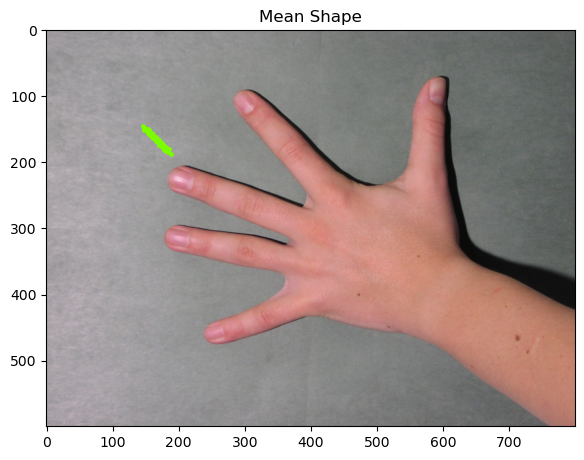

In [109]:
def visualize_mu_and_effect_of_weights(datapoints, mu, pca_components, pca_weights, k):
    # visualize the mean shape and the effect of the first k weights on the mean shape
    # datapoints: the data points
    # mu: the mean shape
    # pca_components: the principal components
    # pca_weights: the weights of the principal components
    # k: the number of principal components to use

    # display the mean shape
    display_image_with_points(img_task1, mu, title="Mean Shape")

    # # display the effect of the first k weights on the mean shape
    # for i in range(k):
    #     display_image_with_points(img_task1, mu + pca_weights[i]*pca_components[:, i], title="Effect of {} weight on mean shape".format(i+1))

visualize_mu_and_effect_of_weights(train_data, train_data.mean(axis=1), pca_components, pca_weights, 5)

### 2 Inference

Given the test shape in *hand_aligned_test.txt* and the generated model
M, estimate the values of $h_{ik}$ using the ICP approach. Also, visualize the reconstructed
shapes and calculate the RMS error between the reconstructed shape and
the original shape for all of the iterations.


### 3 Eigenfaces

In this exercise, we will perform face detection and face recognition
using the Eigenfaces method. Here, you are allowed to use the scikit-learn library.

(a) Use PCA to learn the k principal component of face images in the LFW dataset.
Split the data randomly into 80% for training and 20% for testing. Display
the first 10 Eigenfaces. Find the average reconstruction error of the images
residing in data/task3/detect/face using the k principal components. You
can set k = 100 or any other reasonable value.

In [110]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=65, resize=0.5, download_if_missing=True)

In [111]:
lfw_dataset.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [114]:
items, heught, width = lfw_dataset.images.shape
print("Number of images: ", items)
print("Heught of images: ", heught)
print("Width of images: ", width)

Number of images:  1288
Heught of images:  62
Width of images:  47


In [115]:
X = lfw_dataset.data
y = lfw_dataset.target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
X_train.shape

(1030, 2914)

In [119]:
first_10_images = X_train[:10]
first_10_images = first_10_images.reshape((10, heught, width))
print("First 10 images shape: ", first_10_images.shape)

First 10 images shape:  (10, 62, 47)


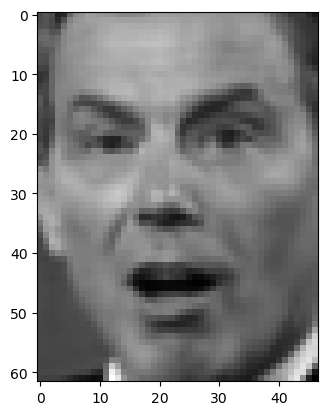

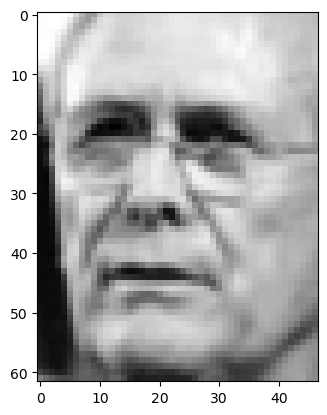

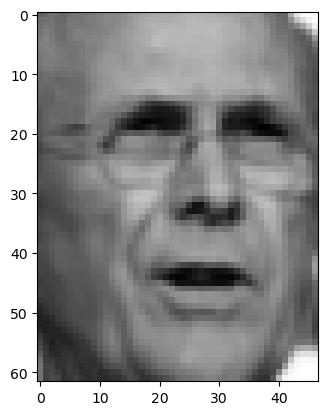

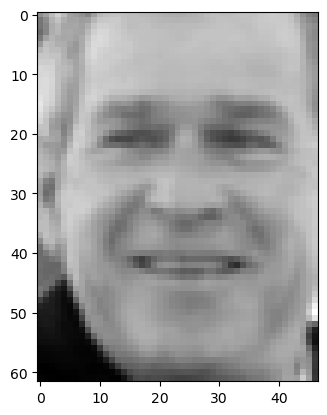

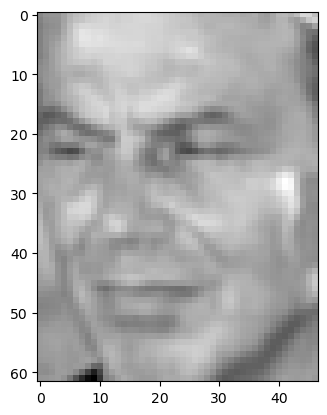

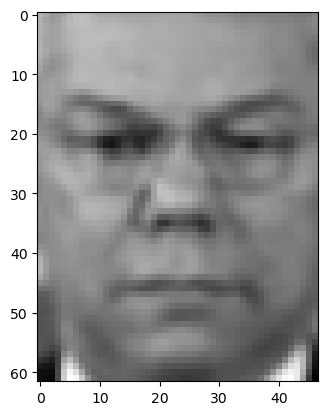

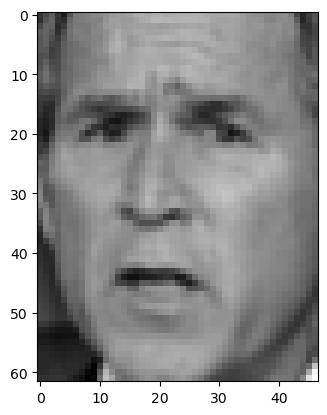

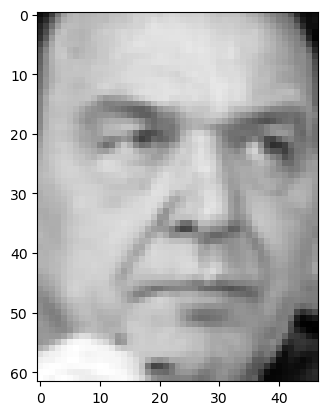

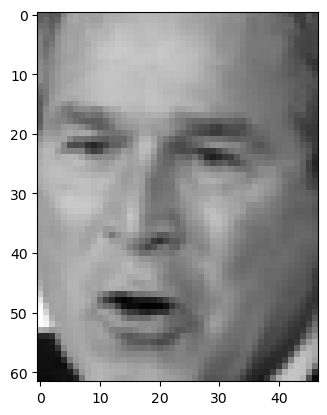

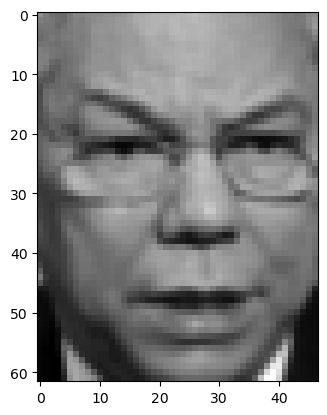

In [120]:
for i in range(first_10_images.shape[0]):
    plt.imshow(first_10_images[i], cmap='gray')
    plt.show()

In [121]:
pca = PCA(n_components=100, whiten=True)
pca.fit(X_train)

PCA(n_components=100, whiten=True)

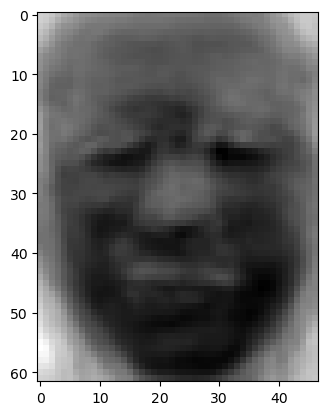

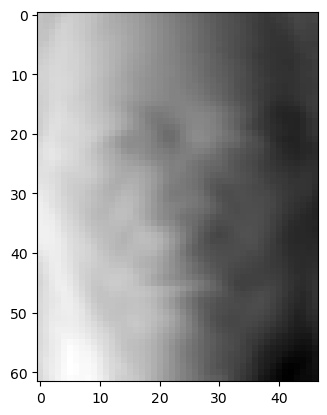

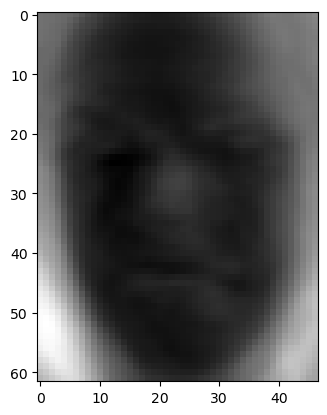

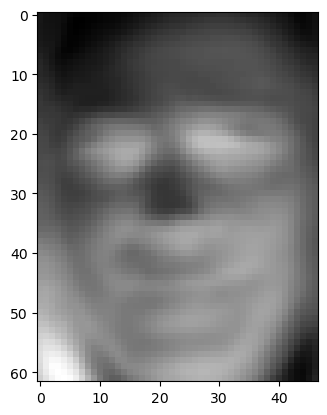

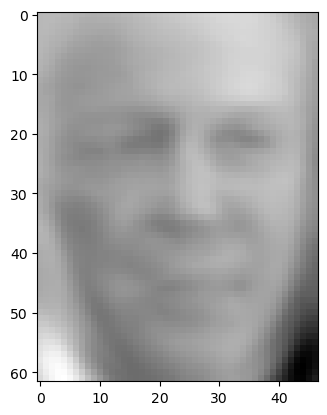

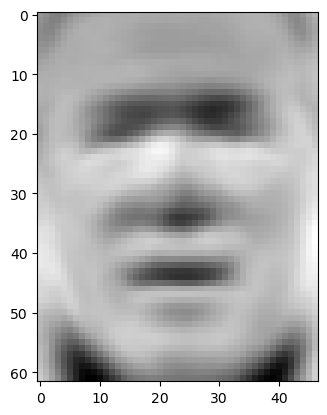

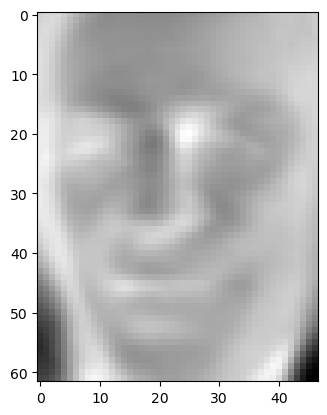

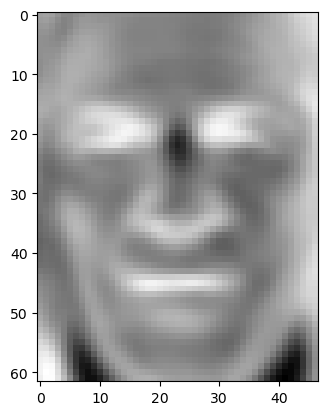

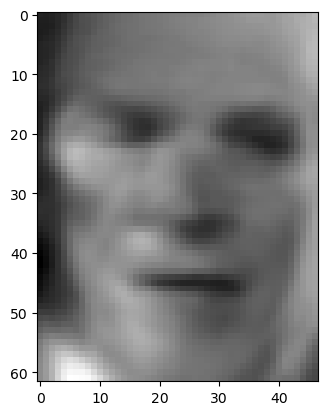

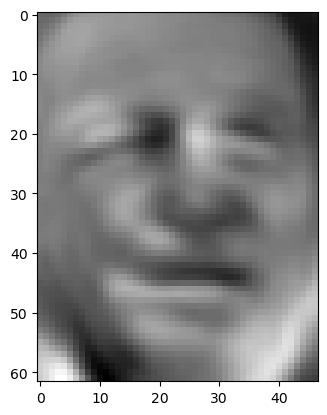

In [123]:
eigenfaces = pca.components_.reshape((100, heught, width))
first_10_eigenfaces = eigenfaces[:10]

for i in range(first_10_eigenfaces.shape[0]):
    plt.imshow(first_10_eigenfaces[i], cmap='gray')
    plt.show()

In [ ]:
face_path = './data/task3/face.jpg'